In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [2]:
#print('script started!',flush=True)
t0 = time()
data = pd.read_csv('ISCX_Botnet_Labelled.csv')
#data = pd.read_csv('/Users/csstnns/Downloads/CSV/data/ISCX_Testing_Sogou_Sampled.csv')
t1 = time()
print('data loaded in %f seconds'%(t1-t0),flush=True)

data loaded in 18.711102 seconds


In [3]:
data.shape

(10000, 7610)

### Check class distribution .. is it balanced?

In [4]:
# Explore BotNet_Label values
s = data['BotNet_Label'].value_counts()

In [5]:
# get a list of labels where the number of instances is > 10
labels = list(s[s > 10].index)

In [6]:
# remove BotNets where the number of instances is < 10
data = data[data['BotNet_Label'].isin(labels)]
data['BotNet_Label'].value_counts()

Normal          4918
Weasel Bot      2127
Virut           1367
Neris            739
Murlo            420
Menti            163
IRC              140
Zero access       59
TBot              23
Black hole 2      14
Zeus              12
Name: BotNet_Label, dtype: int64

In [7]:
#data.columns

### Missing value imputation

In [7]:
## FlowGenerator uses ? for a missing value .. let's replace it with NaN
data.replace('?', np.NaN,inplace=True)
print('symbol ? replaced with NaN',flush=True)
# using isnull() function  
data.isnull().values.any()

symbol ? replaced with NaN


False

In [8]:
## Only run this code if your data contains NaNs
## Replace NaNs with the median of the column
#t2 = time()
#for c in data.columns:
#    if c != 'BotNet_Label':
#        data[c] = pd.to_numeric(data[c], errors='coerce')
#        data[c] = data[c].replace(np.NaN,data[c].median())
#save data so we can use it later
#data.to_csv('no_nans.csv',index=False)
#print('NaN values replaced with median in %f'%(t2-t1),flush=True)

NaN values replaced with median in 0.830833


### Plot Correlation Matrix to Check for Highly Correlated Features

In [8]:
## use all columns except protocol and ports to save time
tmp_df = data[['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s','Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 
'Flow IAT Min','Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min','Bwd IAT Mean',
'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min','Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
       'Idle Std', 'Idle Max', 'Idle Min']]

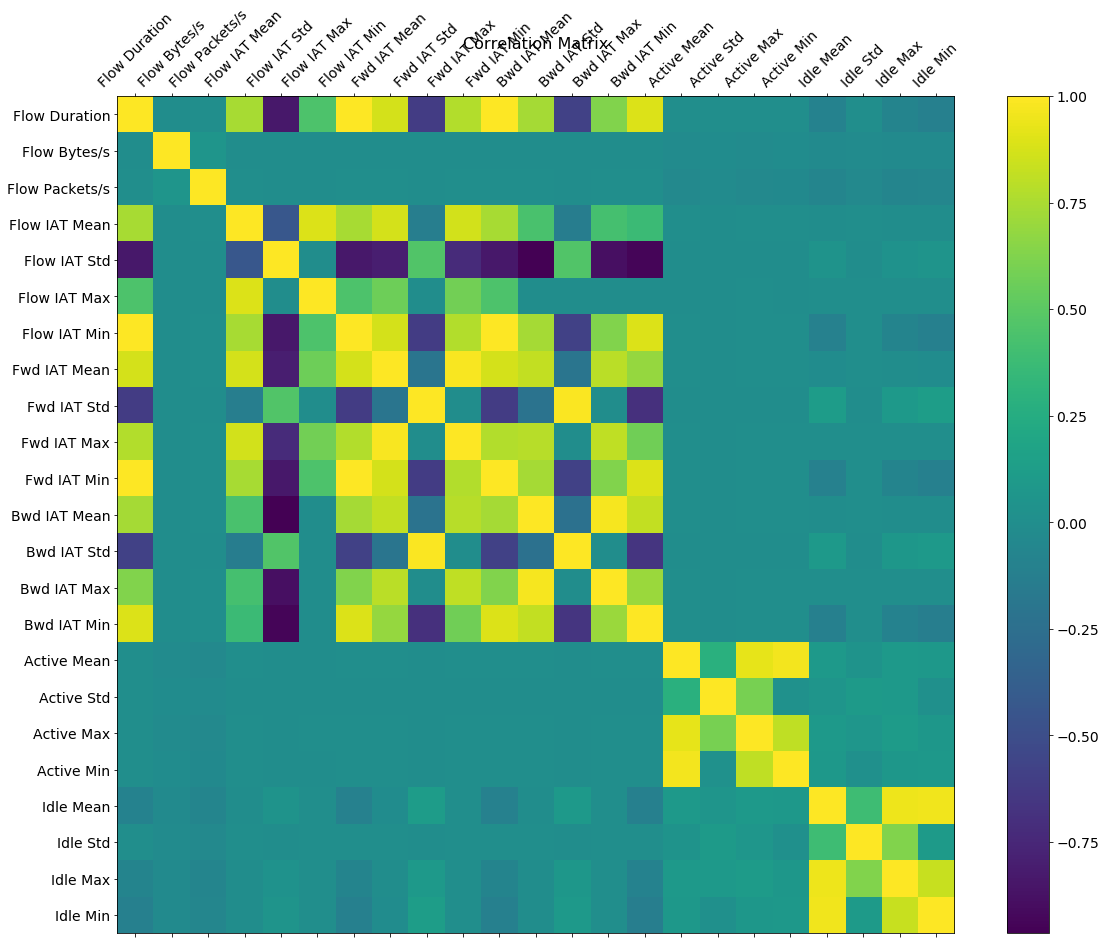

In [9]:
f = plt.figure(figsize=(19, 15))
plt.matshow(tmp_df.corr(), fignum=f.number)
plt.xticks(range(tmp_df.shape[1]), tmp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(tmp_df.shape[1]), tmp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

#### Do it Programmatically

In [9]:
# Create correlation matrix
corr_matrix = tmp_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['Flow IAT Min',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Active Min',
 'Idle Max',
 'Idle Min']

#### Do you want to drop highly correlated features?

In [10]:
#remove highly correlated columns
data.drop(to_drop,axis=1, inplace=True)

In [11]:
t2 = time()

Y = data['BotNet_Label']
data.drop('BotNet_Label', axis=1, inplace=True)

#remove single quote from column name
#rm_quote = lambda x: x.replace('\'', '')
#cols = data.columns
#data.columns = [rm_quote(x) for x in cols]

t3 = time()
print('X (data) and Y matrices prepared in %f'%(t3-t2),flush=True)

X (data) and Y matrices prepared in 0.885880


### Run Outlier Detection and Removal?

In [12]:
outliers_fraction = 0.5
rng = np.random.RandomState(42)

# fit the model
#clf = IsolationForest(contamination=outliers_fraction, random_state=rng, n_jobs=60)
#clf = EllipticEnvelope(contamination=outliers_fraction)
clf = LocalOutlierFactor(n_neighbors=25, contamination=outliers_fraction)
y_pred = clf.fit_predict(data)#only for LocalOutlierFactor
t5 = time()
print('X (data) predicted in %f'%(t5-t3),flush=True)

data['Outlier'] = y_pred
data['BotNet_Label'] = Y

outlier_mask = data['Outlier'].isin([-1])

print('To apply mask and removed outliters',flush=True)
data = data.loc[~outlier_mask]
data.drop('Outlier', axis=1, inplace=True)
print('data to be saved',flush=True)
#data.to_csv('no_outliers.csv',index=False)
t6 = time()
print('data saved in %f'%(t6-t5),flush=True)

X (data) predicted in 198.039665
To apply mask and removed outliters
data to be saved
data saved in 3.916666


In [13]:
data.shape

(4991, 7601)

In [14]:
#save subdatasets
#labels = list(data['BotNet_Label'].unique())
#for label in labels:
#    tlbl = label.replace(" ", "_")#if label has space replace it with _
#    tdata = data[data['BotNet_Label']==label]
#    tdata.to_csv('Bot_'+tlbl+'.csv',index=False)
#    print('Done: ',label,len(tdata))

#print('all done', flush=True)

In [15]:
data.shape

(4991, 7601)

In [16]:
data['BotNet_Label'].value_counts()

Normal         2237
Weasel Bot     1381
Virut           636
Neris           281
Murlo           275
Menti            87
IRC              68
Zero access      13
TBot             10
Zeus              3
Name: BotNet_Label, dtype: int64

In [17]:
# Explore BotNet_Label values
s = data['BotNet_Label'].value_counts()

# get a list of labels where the number of instances is > 10
labels = list(s[s > 10].index)

# remove BotNets where the number of instances is < 10
data = data[data['BotNet_Label'].isin(labels)]
data['BotNet_Label'].value_counts()

Normal         2237
Weasel Bot     1381
Virut           636
Neris           281
Murlo           275
Menti            87
IRC              68
Zero access      13
Name: BotNet_Label, dtype: int64

### SMOTE (Synthetic Minority Oversampling Technique) – Oversampling

* It aims to balance class distribution by randomly increasing minority class examples by replicating them.
* SMOTE synthesises new minority instances between existing minority instances. 
* It generates the virtual training records by linear interpolation for the minority class.
* These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. 

In [18]:
#!pip install -U imbalanced-learn

In [19]:
%%time
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
# separate features from class variable
y = data['BotNet_Label']
X = data.drop('BotNet_Label', axis=1)

X, y = sm.fit_sample(X, y.ravel())

Using TensorFlow backend.


CPU times: user 23.7 s, sys: 6.48 s, total: 30.2 s
Wall time: 48.2 s


In [20]:
y.shape

(17896,)

In [21]:
targets = np.unique(y).tolist()
len(targets)

8

### Principal Component Analysis (PCA)

In [22]:
# Apply StandardScaler so all values are between 0-1
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [23]:
# Apply PCA from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
# create a datarame that contains the PCA components
principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])

In [24]:
# add the class label to the PCA components
principal_df['BotNet_Label'] = y

In [25]:
principal_df.head()

,principal component 1,principal component 2,BotNet_Label
0,-1.238287,2.675245,IRC
1,-0.520907,-1.224959,IRC
2,-0.684232,-1.622258,Normal
3,-1.307431,2.670355,Normal
4,-0.935993,-1.209454,Menti


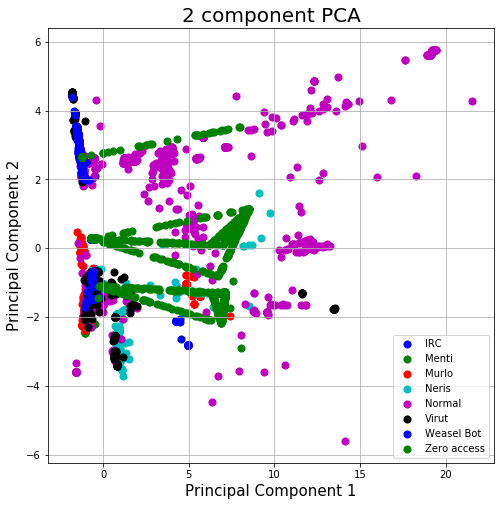

In [26]:
from itertools import cycle

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['Neris', 'Normal', 'TBot', 'RBot']
#colors = ['r', 'g', 'b','c']


cycol = cycle('bgrcmk')

    
for target in targets:
    indicesToKeep = principal_df['BotNet_Label'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'principal component 1']
               , principal_df.loc[indicesToKeep, 'principal component 2']
               , c = next(cycol)
               , s = 50)
ax.legend(targets)
ax.grid()

In [27]:
targets

['IRC',
 'Menti',
 'Murlo',
 'Neris',
 'Normal',
 'Virut',
 'Weasel Bot',
 'Zero access']

### Use your Favourite Classifier to Make Predictions

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

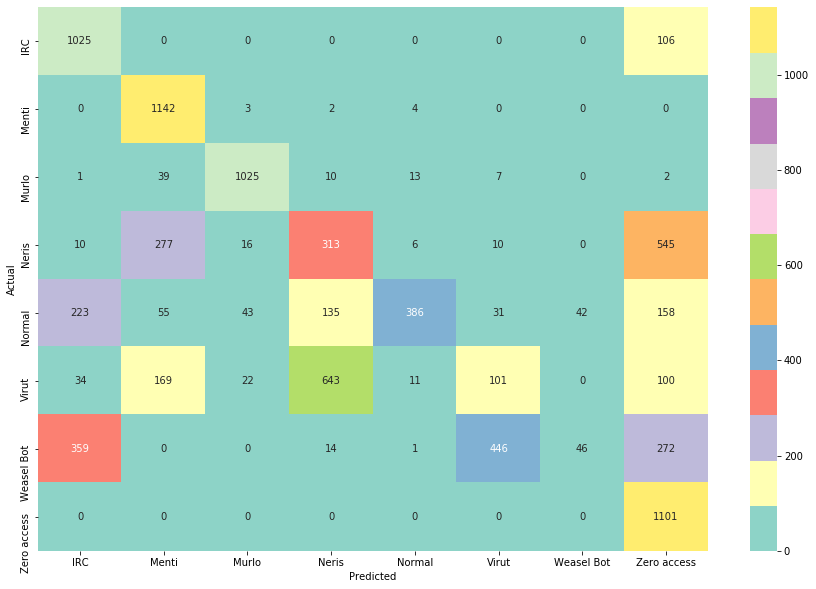

CPU times: user 7.17 s, sys: 4.89 s, total: 12.1 s
Wall time: 15.8 s


In [29]:
%%time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = gnb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)


# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=targets, yticklabels=targets)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [38]:
from sklearn.metrics import accuracy_score

print("Accuracy: " , (accuracy_score(y_test, y_pred)))

Accuracy:  0.5743182834152883


# Well Done!